ЛР 3. Задание
https://api.hh.ru/vacancies?text=DATA+ENGINEER&area=1&search_field=name

In [143]:
import requests
import pandas as pd
import re
import scipy.stats as st
import numpy as np

### 1. Скачать 200 вакансий разработчик Питон из г. Москвы + 200 вакансий из г. Санкт-Петербург
### 2. Полученные json объединить в один датафрейм pandas

In [144]:
URL = "https://api.hh.ru/vacancies?text=разработчик+Python&area={}&search_field=name&per_page=100"

df = pd.DataFrame()
for j in range(1, 3):
    for i in range(2):
        df_some = pd.concat(
            [
                df,
                (
                    pd.json_normalize(
                        requests.get(URL.format(str(j)) + "&page=" + str(i)).json()[
                            "items"
                        ]
                    )
                ),
            ]
        )

In [169]:
df_some = df[
    [
        "id",
        "name",
        "area.name",
        "salary.from",
        "salary.to",
        "salary.currency",
        "salary.gross",
        "snippet.requirement",
        "snippet.responsibility",
        "employer.accredited_it_employer",
        "schedule.id",
        "experience.id",
    ]
].copy()

df_some.head()

,id,name,area.name,salary.from,salary.to,salary.currency,salary.gross,snippet.requirement,snippet.responsibility,employer.accredited_it_employer,schedule.id,experience.id
0,100389204,Разработчик Python (junior),Москва,60000.0,70000.0,RUR,False,Высшее техническое образование. Опыт программи...,Поддержка и развитие существующего кода бекенд...,False,fullDay,between1And3
1,101143108,Junior Python разработчик,Москва,NaN,NaN,NaN,NaN,Высшее техническое образование. Опыт программи...,"Разработка и поддержка fullstack - решений, вк...",False,fullDay,noExperience
2,101350542,Python разработчик (Intern),Москва,NaN,NaN,NaN,NaN,"Знание <highlighttext>Python</highlighttext>, ...","Разработка ботов, на языке <highlighttext>Pyth...",False,remote,noExperience
3,101287826,Junior Python developer,Москва,NaN,NaN,NaN,NaN,"Знание английского языка на уровне, достаточно...",Разработка отдельных модулей для сервисов. Реш...,True,fullDay,between1And3
4,98919945,Junior Python-разработчик,Москва,40000.0,60000.0,RUR,True,Уверенное владение языком программирования <hi...,Разработка и тестирование backend-части програ...,False,flexible,noExperience


In [171]:
df_some.info()

<class 'pandas.core.frame.DataFrame'>
Index: 320 entries, 0 to 19
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               320 non-null    object 
 1   name                             320 non-null    object 
 2   area.name                        320 non-null    object 
 3   salary.from                      75 non-null     float64
 4   salary.to                        58 non-null     float64
 5   salary.currency                  91 non-null     object 
 6   salary.gross                     91 non-null     object 
 7   snippet.requirement              320 non-null    object 
 8   snippet.responsibility           314 non-null    object 
 9   employer.accredited_it_employer  320 non-null    bool   
 10  schedule.id                      320 non-null    object 
 11  experience.id                    320 non-null    object 
dtypes: bool(1), float64(2), obje

### 3. По вакансиям с известными зп усреднить зп по мин и макс

Вычисляем значение зарплаты исходя их известных границ

In [174]:
df_some["salary.mean"] = (df_some["salary.from"] + df_some["salary.to"]) / 2


def calc_salaty(row):

    if (row["salary.to"] > 0) and (row["salary.from"] > 0):
        return row["salary.mean"]

    elif row["salary.to"] > 0:
        return row["salary.to"]

    elif row["salary.from"] > 0:
        return row["salary.from"]

    else:
        return np.nan


df_some["salary"] = df_some.apply(calc_salaty, axis=1)

In [175]:
df_some[["salary.from", "salary.to", "salary.mean", "salary"]]

,salary.from,salary.to,salary.mean,salary
0,60000.0,70000.0,65000.0,65000.0
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,40000.0,60000.0,50000.0,50000.0
...,...,...,...,...
15,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN
17,350000.0,NaN,NaN,350000.0
18,NaN,NaN,NaN,NaN


### 4. По вакансиям с неизвестными зп попытаться восстановить пропущенные значения

In [176]:
from sklearn.linear_model import LinearRegression

In [177]:
X = pd.get_dummies(
    df_some[
        [
            "salary",
            "area.name",
            "salary.currency",
            "salary.gross",
            "employer.accredited_it_employer",
            "schedule.id",
            "experience.id",
        ]
    ]
)
X

,salary,employer.accredited_it_employer,area.name_Москва,area.name_Санкт-Петербург,salary.currency_EUR,salary.currency_RUR,salary.currency_USD,salary.gross_False,salary.gross_True,schedule.id_flexible,schedule.id_fullDay,schedule.id_remote,experience.id_between1And3,experience.id_between3And6,experience.id_moreThan6,experience.id_noExperience
0,65000.0,False,True,False,False,True,False,True,False,False,True,False,True,False,False,False
1,NaN,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True
2,NaN,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
3,NaN,True,True,False,False,False,False,False,False,False,True,False,True,False,False,False
4,50000.0,False,True,False,False,True,False,False,True,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,NaN,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False
16,NaN,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False
17,350000.0,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False
18,NaN,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False


Отбиарем признаки для линейной регрессии

In [198]:
X_train = X.loc[pd.notnull(X["salary"]), X.columns[1:]]

Y_train = df_some.loc[pd.notnull(df_some["salary"]), "salary"]

Y_train_log = np.log1p(Y_train)

In [187]:
X_train.shape, Y_train.shape

((91, 15), (91,))

In [199]:
model = LinearRegression()
# results = model.fit(X_train, Y_train)
results = model.fit(X_train, Y_train_log)

In [200]:
results.coef_, results.intercept_

(array([-0.03670987,  0.02527171, -0.02527171, -1.61535464,  2.72640824,
        -1.1110536 , -0.01518489,  0.01518489, -0.15387959,  0.07741674,
         0.07646285, -0.3826759 ,  0.07514354,  0.5254797 , -0.21794734]),
 9.415380150574128)

In [201]:
# df_some["Predicted salary"] = model.predict(X.iloc[:, 1:])
df_some["Predicted salary"] = np.expm1(model.predict(X.iloc[:, 1:]))

In [202]:
from sklearn.metrics import mean_absolute_error

In [203]:
mean_absolute_error(
    df_some.dropna()["salary"],
    df_some.dropna()["Predicted salary"],
)

41704.04318999329

In [208]:
df_some["salary"].describe()

count        91.000000
mean     189277.472527
std      125905.577774
min        3750.000000
25%      120000.000000
50%      165000.000000
75%      207500.000000
max      700000.000000
Name: salary, dtype: float64

In [205]:
df_some["Predicted salary"].describe()

count       320.000000
mean      57748.204229
std       79844.975797
min        4500.000000
25%        9276.920317
50%       14121.836519
75%      132634.135036
max      356874.205160
Name: Predicted salary, dtype: float64

Собираем известные и предсказанные значения зарплаты

In [210]:
df_some["salary.full"] = df_some["salary"].fillna(df_some["Predicted salary"])

### 5. Построить ящичковую диаграмму по распределению зп внутри города

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

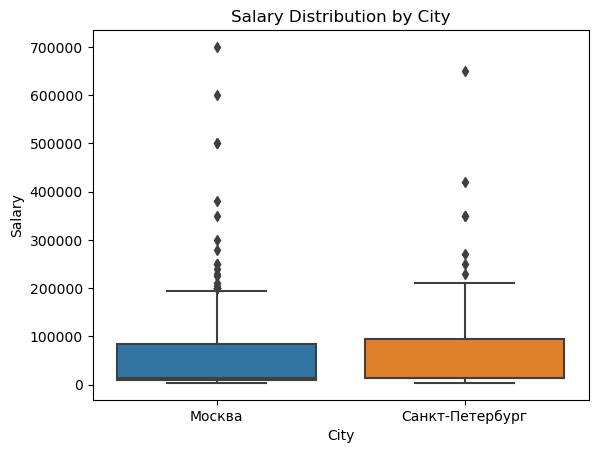

In [220]:
sns.boxplot(x="area.name", y="salary.full", data=df_some)
plt.title("Salary Distribution by City")
plt.xlabel("City")
plt.ylabel("Salary")
plt.show()

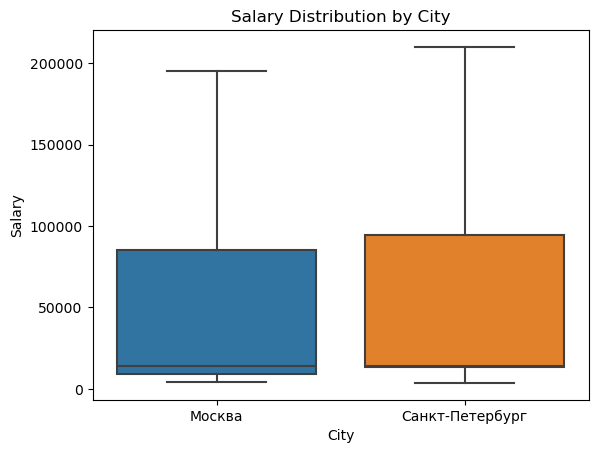

In [219]:
sns.boxplot(x="area.name", y="salary.full", data=df_some, showfliers=False)
plt.title("Salary Distribution by City")
plt.xlabel("City")
plt.ylabel("Salary")
plt.show()

Есть довольно низкие значения, связанные с указанием зарплаты не в рублях

In [231]:
df_some[df_some["area.name"] == "Москва"]["salary.full"].describe()

count       200.000000
mean      62315.678401
std      106774.495034
min        4000.000000
25%        9276.920317
50%       14135.314612
75%       85000.000000
max      700000.000000
Name: salary.full, dtype: float64

In [223]:
df_some[df_some["area.name"] == "Санкт-Петербург"]["salary.full"].describe()

count       120.000000
mean      63576.370697
std      100203.684601
min        3750.000000
25%       13425.759317
50%       13941.105570
75%       94375.000000
max      650000.000000
Name: salary.full, dtype: float64

In [225]:
df_some['salary.currency'].value_counts()

salary.currency
RUR    87
USD     3
EUR     1
Name: count, dtype: int64

In [235]:
df_some[(df_some["salary.currency"] == "USD") | (df_some["salary.currency"] == "EUR")]

,id,name,area.name,salary.from,salary.to,salary.currency,salary.gross,snippet.requirement,snippet.responsibility,employer.accredited_it_employer,schedule.id,experience.id,salary.mean,salary,Predicted salary,salary.full,salary.full.rur
20,100811009,Python Backend Developer (middle+/senior),Москва,NaN,4000.0,USD,False,Отличное знание <highlighttext>Python</highlig...,Проектирование и разработка сервисов. Контроль...,False,remote,between3And6,NaN,4000.0,4749.569364,4000.0,4000.0
30,100616034,Senior Python Developer,Москва,NaN,7000.0,USD,False,Опыт от 5-ти лет на <highlighttext>Python</hig...,"Разработка, поддержка и масштабирование веб-пр...",False,remote,between3And6,NaN,7000.0,4749.569364,7000.0,7000.0
42,100063531,Python Developer (senior),Москва,4500.0,NaN,EUR,False,Требуемые навыки: Более 5 лет практического оп...,None,False,remote,moreThan6,NaN,4500.0,4500.000000,4500.0,4500.0
38,101270894,Python Developer,Санкт-Петербург,3500.0,4000.0,USD,True,Большой опыт разработки на <highlighttext>Pyth...,Руководить разработкой и внедрением продукта. ...,False,remote,between3And6,3750.0,3750.0,4654.693331,3750.0,3750.0


### 6. ЗП исправить убрать налог, если валюта зп не равна рублям заменить по текущему курсу обмена

In [232]:
# Курсы валют
usd_to_rub = 88  
eur_to_rub = 97 

Перевод в рубли

In [239]:
df_some["salary.full.rur"] = np.where(
    df_some["salary.currency"] == "USD",
    df_some["salary.full"] * usd_to_rub,
    np.where(
        df_some["salary.currency"] == "EUR",
        df_some["salary.full"] * eur_to_rub,
        df_some["salary.full"],
    ),
)

Вычет налога

In [244]:
df_some["salary.no_tax"] = np.where(
    df_some["salary.gross"] == True, df_some["salary.full.rur"] * 0.87, df_some["salary.full.rur"]
)

### 6.1 Обучим модель на правильной зарплате

In [251]:
df_some["salary.clean"] = np.where(
    pd.isnull(df_some["salary"]) == True, np.nan, df_some["salary.no_tax"]
)

In [254]:
X = pd.get_dummies(
    df_some[
        [
            "salary.clean",
            "area.name",
            "salary.currency",
            "salary.gross",
            "employer.accredited_it_employer",
            "schedule.id",
            "experience.id",
        ]
    ]
)
X

,salary.clean,employer.accredited_it_employer,area.name_Москва,area.name_Санкт-Петербург,salary.currency_EUR,salary.currency_RUR,salary.currency_USD,salary.gross_False,salary.gross_True,schedule.id_flexible,schedule.id_fullDay,schedule.id_remote,experience.id_between1And3,experience.id_between3And6,experience.id_moreThan6,experience.id_noExperience
0,65000.0,False,True,False,False,True,False,True,False,False,True,False,True,False,False,False
1,NaN,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True
2,NaN,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
3,NaN,True,True,False,False,False,False,False,False,False,True,False,True,False,False,False
4,43500.0,False,True,False,False,True,False,False,True,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,NaN,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False
16,NaN,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False
17,350000.0,False,False,True,False,True,False,True,False,False,True,False,False,True,False,False
18,NaN,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False


Отбиарем признаки для линейной регрессии

In [257]:
X_train = X.loc[pd.notnull(X["salary.clean"]), X.columns[1:]]

Y_train = df_some.loc[pd.notnull(df_some["salary.clean"]), "salary.clean"]

Y_train_log = np.log1p(Y_train)

In [258]:
X_train.shape, Y_train.shape

((91, 15), (91,))

In [259]:
model = LinearRegression()
# results = model.fit(X_train, Y_train)
results = model.fit(X_train, Y_train_log)

In [260]:
results.coef_, results.intercept_

(array([-0.03671012,  0.02527293, -0.02527293, -0.05806848, -0.2907951 ,
         0.34886358,  0.0544474 , -0.0544474 , -0.15387811,  0.07741674,
         0.07646137, -0.38267589,  0.07514357,  0.52548051, -0.2179482 ]),
 12.362952204316676)

In [261]:
# df_some["Predicted salary"] = model.predict(X.iloc[:, 1:])
df_some["Predicted salary_new"] = np.expm1(model.predict(X.iloc[:, 1:]))

In [262]:
mean_absolute_error(
    df_some.dropna()["salary.clean"],
    df_some.dropna()["Predicted salary_new"],
)

42920.201818497786

In [263]:
df_some["salary.full_new"] = df_some["salary.clean"].fillna(
    df_some["Predicted salary_new"]
)

In [ ]:
df_some.sort_values(by="salary.clean")

In [268]:
df_some["salary.no_tax"].describe()

count       320.000000
mean      66541.875512
std      109281.580617
min        6745.931495
25%        9276.920317
50%       14135.314612
75%      100000.000000
max      700000.000000
Name: salary.no_tax, dtype: float64

In [270]:
df_some["salary.clean"].describe()

count        91.000000
mean     202476.373626
std      127253.848521
min       43500.000000
25%      121800.000000
50%      170000.000000
75%      210000.000000
max      700000.000000
Name: salary.clean, dtype: float64

In [269]:
df_some["salary.full_new"].describe()

count       320.000000
mean     228416.961051
std       87734.317463
min       43500.000000
25%      173114.746748
50%      209249.433264
75%      269432.078662
max      700000.000000
Name: salary.full_new, dtype: float64

После обучения на зарплате с вычетом налогов и приведению к одной валюте значения стали более правдивыми

### 7. Добавить к графику 5. столбцы с распределением чистой эп.

До заполнения пропусков моделью

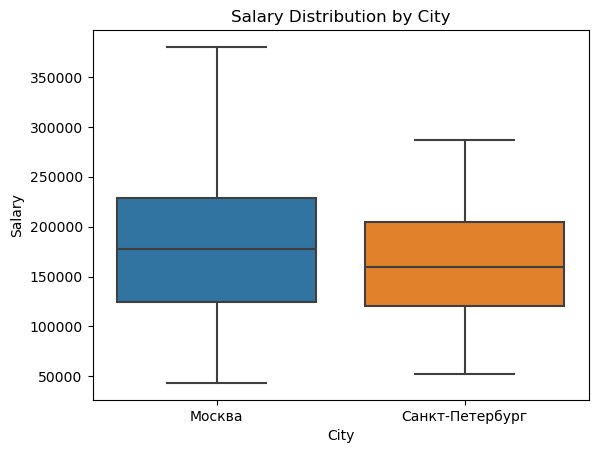

In [273]:
sns.boxplot(x="area.name", y="salary.clean", data=df_some, showfliers=False)
plt.title("Salary Distribution by City")
plt.xlabel("City")
plt.ylabel("Salary")
plt.show()

После заполнения пропусков моделью

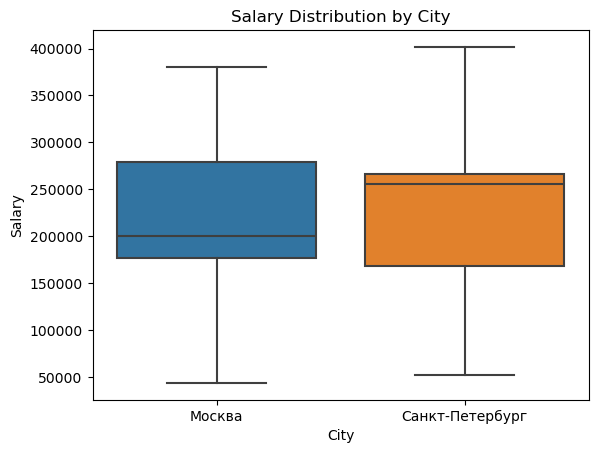

In [271]:
sns.boxplot(x="area.name", y="salary.full_new", data=df_some, showfliers=False)
plt.title("Salary Distribution by City")
plt.xlabel("City")
plt.ylabel("Salary")
plt.show()

### 8. Построить гистограмму упоминания навыков в вакансиях. Навыком считаем язык или фреймворк, или инструмент на англ.









-


9. Построить для junior, middle, senior, столбиковую диаграмму со средней зп внутри уровня
10. Проверить гипотезу, о том что уровень вакансии НЕ влияет на эп
Последнее изменение: вторник, 26 декабря 2023, 14:14